In [20]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import py_vollib.black_scholes.implied_volatility as bs
import time
from scipy.interpolate import CubicSpline

import cos_method as COS
from hawkes_class import Hawkes
from qhawkes_class import QHawkes
from heston_class import Heston
from jumpdiff_class import JumpDiffusion
from poisson_class import Poisson
from pricing_functions import price_vanilla

np.set_printoptions(threshold=sys.maxsize)

Characteristic function of the Bates model for Bermudan option pricing (should go in its proper class in future update)

In [21]:
def bates_cf_bermudan(u,t,n,heston_cf_bermudan,poi_cf):
    cfV,vV = heston_cf_bermudan(u,t,n)
    return cfV*poi_cf(u,t),vV

Initialize parameters

In [31]:
T  = 1                     # Maturity
N  = 10000                 # MC paths
S0 = 9                     # Asset's initial value
K  = 10                    # Strike
X0 = np.log(S0/K)          # Normalized log-stock
r  = 0.1                   # Interest rate

# Diffusion parameters
V0   = 0.0625   # Initial value
rho  = 0.1      # Correlation
eta  = 0.9      # Vol of vol
lamb = 5        # Speed of mean-reversion
nu   = 0.16     # Long-term variance

# Jump parameters
a  = 2.9                   # Clustering rate
b  = 3.                    # Expiration rate
hb = 1.1                   # Baseline intensity
Q0 = 2                     # Initial activation
h0 = hb + a*Q0             # Initial intensity
mj = 0.3                   # Mean of log-jump size
sj = 0.4                   # Volatility of log-jump size

# Characteristic function and cumulants of the log-jump size distribution.
# Here we assume a normal distribution.
eJ = np.exp(mj+sj**2/2)-1
fu = lambda u: np.exp(1j*u*mj-sj**2*u**2/2)
cm = [mj,mj**2+sj**2,mj**3+3*mj*sj**2,mj**4+6*mj**2*sj**2+3*sj**4]

Initialize the classes

In [32]:
qhawk    = QHawkes(a,b,hb,Q0,cm,eJ,fu)
hawk     = Hawkes(a,b,hb,Q0,cm,eJ,fu)
poi      = Poisson(a,b,hb,Q0,cm,eJ,fu)
heston   = Heston(S0,V0,r,lamb,nu,eta,rho)
heston_e = JumpDiffusion(heston,qhawk)
heston_h = JumpDiffusion(heston,hawk)
heston_p = JumpDiffusion(heston,poi)

Price European options

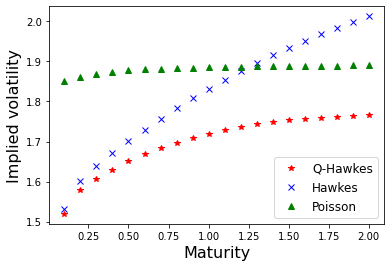

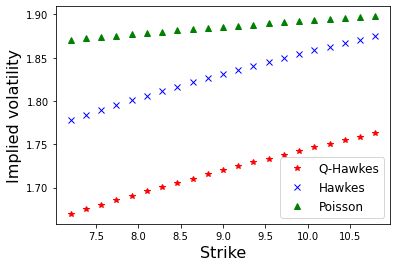

In [33]:
x0  = np.array([0,V0,Q0])
Kv  = S0*np.linspace(0.8,1.2,21,endpoint=True)  # Strike grid
Tv  = np.linspace(0.1,2,20,endpoint=True)       # Maturity grid
nK  = Kv.size
nT  = Tv.size

Pq,IVq,Delta_q = price_vanilla(heston_e,S0,Tv,Kv,r,x0,alpha=-1)
Ph,IVh,Delta_h = price_vanilla(heston_h,S0,Tv,Kv,r,x0,alpha=-1)
Pp,IVp,Delta_p = price_vanilla(heston_p,S0,Tv,Kv,r,x0,alpha=-1)

# Fixed strike
idK = 10
plt.figure()
plt.plot(Tv,IVq[:,idK],'r*')
plt.plot(Tv,IVh[:,idK],'bx')
plt.plot(Tv,IVp[:,idK],'g^')
plt.xlabel('Maturity',fontsize=16)
plt.ylabel('Implied volatility',fontsize=16)
plt.legend(('Q-Hawkes','Hawkes','Poisson'),fontsize=12,loc='lower right')
plt.show()

# Fixed maturity
idT = 9
plt.figure()
plt.plot(Kv,IVq[idT,:],'r*')
plt.plot(Kv,IVh[idT,:],'bx')
plt.plot(Kv,IVp[idT,:],'g^')
plt.xlabel('Strike',fontsize=16)
plt.ylabel('Implied volatility',fontsize=16)
plt.legend(('Q-Hawkes','Hawkes','Poisson'),fontsize=12)
plt.show()

Price Bermudan options

In [ ]:
cfV     = lambda u,t,n: heston.cf_bermudan(u,Tv[idT],t,n)
cfPoi   = lambda u,t:   poi.cf_cj(u,0,t,Q0)
cfBates = lambda u,t,n: bates_cf_bermudan(u,t,n,cfV,cfPoi)
cfQ     = lambda u,t,n: qhawk.cf_bermudan(u,t,n)
cfH     = lambda u,t,n: hawk.cf_bermudan(u,t,n)

av,bv = heston.logvar_bounds(Tv[idT])   # Boundaries for the Heston variance

nM   = 10
M    = np.arange(1,nM+1)                # Number of exercise dates
Pq2  = np.zeros((nM,))                  # Prices
Pp2  = np.zeros_like(Pq2)
Ph2  = np.zeros_like(Pq2)
IVbe = np.zeros_like(Pq2)               # Implied volatilities
IVbh = np.zeros_like(Pq2)
IVbp = np.zeros_like(Pq2)

time_e = 0
time_h = 0
time_p = 0
nrep   = 1                              # Number of repetitions (for profiling purposes)
for k in range(nrep):
    for i in range(nM):
        # Heston-Q-Hawkes
        cme      = heston_e.cumulants_cos(Tv[idT]/M[i])
        cme[0]  -= np.log(Kv[idK])
        time1    = time.time()
        Pb,Vb,Qb = COS.bermudan_put_3D(S0,Kv[idK],Tv[idT],r,cme,M[i],cfV,
                                       cfQ,N1=2**6,n1=2**5,n2=2**5)
        time_e += (time.time()-time1)
        Pq2[i]  = CubicSpline(Vb,Pb[:,Q0,:],axis=0)(V0)
        IVbe[i] = bs.implied_volatility(Pq2[i],S0,Kv[idK],Tv[idT],r,'p')
        #
        # Bates model
        cmp         = heston_p.cumulants_cos(Tv[idT]/M[i])
        cmp[0]     -= np.log(Kv[idK])
        time1       = time.time()
        Pbp,Vbp,Qbp = COS.bermudan_put_3D(S0,Kv[idK],Tv[idT],r,cmp,M[i],cfBates,
                                          N1=2**6,n1=2**5)
        time_p += (time.time()-time1)
        Pp2[i]  = CubicSpline(Vbp,Pbp,axis=0)(V0)
        IVbp[i] = bs.implied_volatility(Pp2[i],S0,Kv[idK],Tv[idT],r,'p')

        # Heston-Hawkes
        cmh         = heston_h.cumulants_cos(Tv[idT]/M[i])
        cmh[0]     -= np.log(Kv[idK])
        time1       = time.time()
        Pbh,Vbh,Qbh = COS.bermudan_put_3D(S0,Kv[idK],Tv[idT],r,cmh,M[i],cfV,
                                          cfH,N1=2**6,n1=2**5,n2=2**5)
        time_h += (time.time()-time1)
        Pbh     = CubicSpline(Qbh,Pbh,axis=1)
        Ph2[i]  = CubicSpline(Vbh,Pbh(Q0))(V0)
        IVbh[i] = bs.implied_volatility(Ph2[i],S0,Kv[idK],Tv[idT],r,'p')

# Notice that Q-Hawkes and Hawkes implementations are considerably slower than Bates for Bermudan options.
# This is most likely due to the extra loop used to avoid excessive memory allocation. A proper comparison
# would require using a compiled language (C/C++) since it does not penalize the extra loop so much.
print(time_e/nrep,time_h/nrep,time_p/nrep)

plt.figure()
plt.plot(M,IVbe,'r*')
plt.plot(M,IVbh,'bx')
plt.plot(M,IVbp,'g^')
plt.xlabel('Exercise dates',fontsize=16)
plt.ylabel('Implied volatility',fontsize=16)
plt.legend(('Q-Hawkes','Hawkes','Poisson'),fontsize=12)
plt.show()